## Real-Time Hand Gesture Recognition with Image Logging and Model Comparison

#### Import Required Libraries

In [1]:
import os, cv2, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### Dataset paths

In [2]:
DATASET_DIR = "Dataset/Gesture_Images"  # Update if needed
SNAPSHOT_DIR = "SavedSnapshots"
os.makedirs(SNAPSHOT_DIR, exist_ok=True)

#### Load images

In [3]:
def load_images(base_dir):
    images, labels = [], []
    for subject in sorted(os.listdir(base_dir)):
        for gesture in sorted(os.listdir(os.path.join(base_dir, subject))):
            gesture_path = os.path.join(base_dir, subject, gesture)
            for img_file in os.listdir(gesture_path):
                img = cv2.imread(os.path.join(gesture_path, img_file), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (64, 64))
                    images.append(img)
                    labels.append(gesture)
    return np.array(images), np.array(labels)

#### Load dataset

In [4]:
X, y = load_images(DATASET_DIR)
print("Loaded:", len(X), "images.")

Loaded: 20000 images.


#### Show class distribution

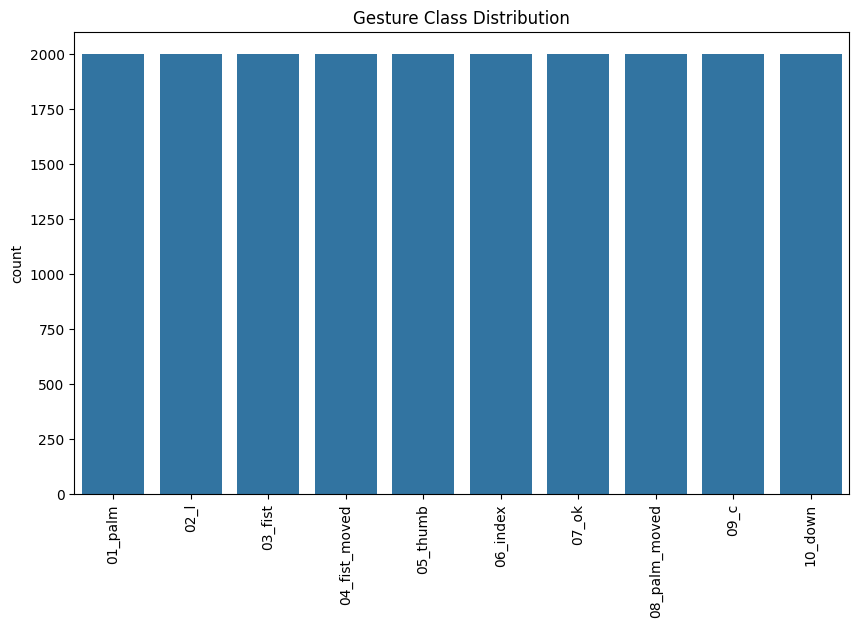

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(x=y)
plt.xticks(rotation=90)
plt.title("Gesture Class Distribution")
plt.show()

#### Encode Labels

In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#### Logging Setup

In [7]:
LOG_PATH = "Logs"
LOG_FILE = os.path.join(LOG_PATH, "prediction_logs.csv")
os.makedirs(LOG_PATH, exist_ok=True)

def log_prediction(source, model, gesture, command, confidence):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    row = {
        "Timestamp": now,
        "Source": source,
        "Model": model,
        "Gesture": gesture,
        "Command": command,
        "Confidence": confidence
    }
    df = pd.DataFrame([row])
    if not os.path.exists(LOG_FILE):
        df.to_csv(LOG_FILE, index=False)
    else:
        df.to_csv(LOG_FILE, mode='a', header=False, index=False)

#### HOG feature extraction

In [8]:
def extract_hog(images):
    return [hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for img in images]

#### Apply HOG

In [9]:
X_hog = extract_hog(X)
print("HOG feature shape:", len(X_hog), len(X_hog[0]))

HOG feature shape: 20000 1764


#### Scaling and PCA

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hog)

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

#### PCA Explained Variance

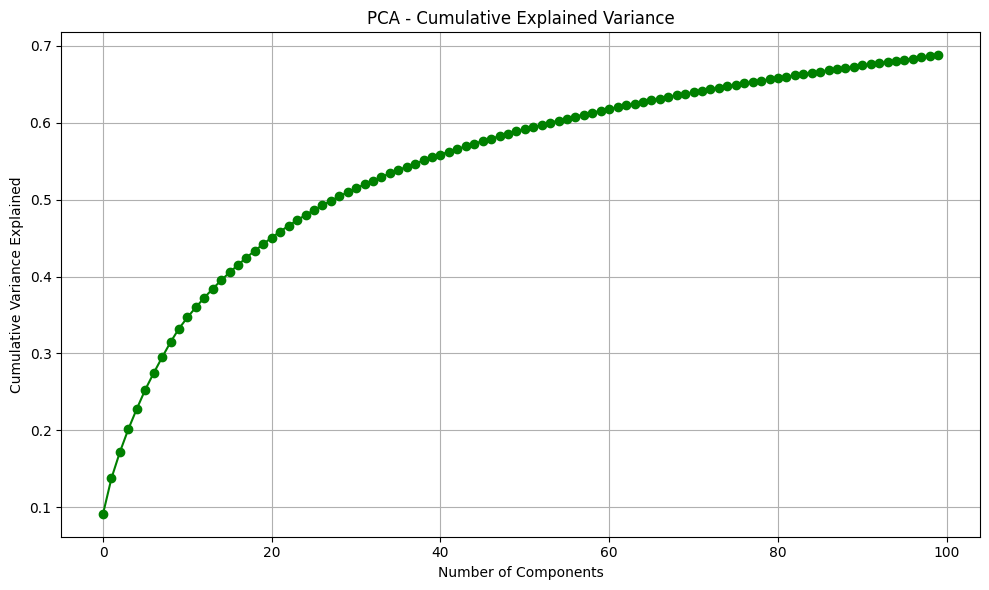

In [11]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='green')
plt.title("PCA - Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

#### Train SVM

In [13]:
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_acc)

SVM Accuracy: 1.0


#### Train Random Forest

In [14]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 1.0


#### Feature Importance from Random Forest

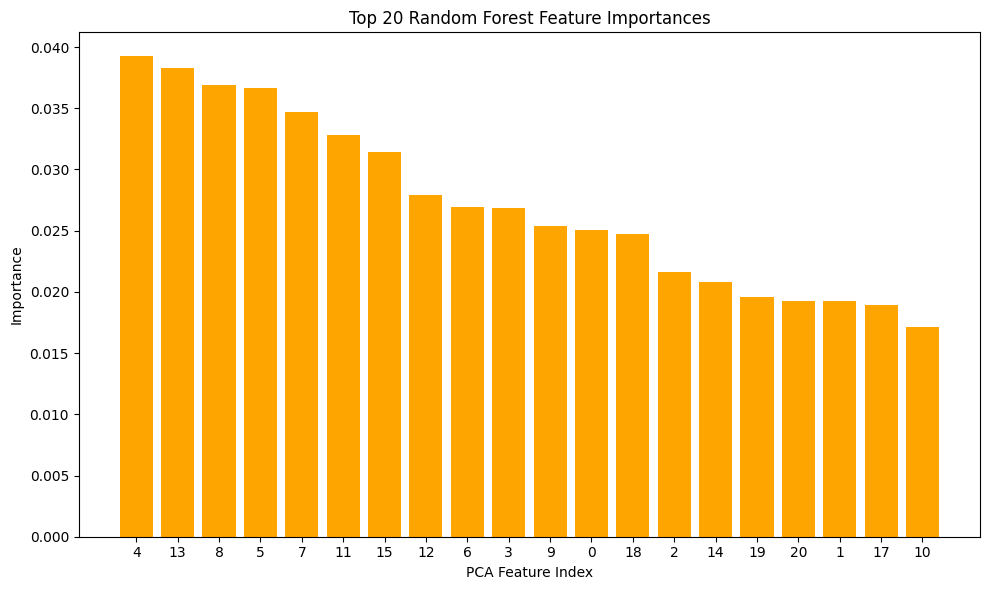

In [15]:
importances = rf_model.feature_importances_
top_indices = np.argsort(importances)[-20:][::-1]  # Top 20

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_indices)), importances[top_indices], align="center", color="orange")
plt.title("Top 20 Random Forest Feature Importances")
plt.xlabel("PCA Feature Index")
plt.ylabel("Importance")
plt.xticks(range(len(top_indices)), top_indices)
plt.tight_layout()
plt.show()

#### Train KNN

In [16]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_acc)

KNN Accuracy: 1.0


#### Compare Accuracies

In [17]:
acc_df = pd.DataFrame({
    "Model": ["SVM", "Random Forest", "KNN"],
    "Accuracy": [svm_acc, rf_acc, knn_acc]
})
print(acc_df)

           Model  Accuracy
0            SVM       1.0
1  Random Forest       1.0
2            KNN       1.0


#### Per-Class Accuracy

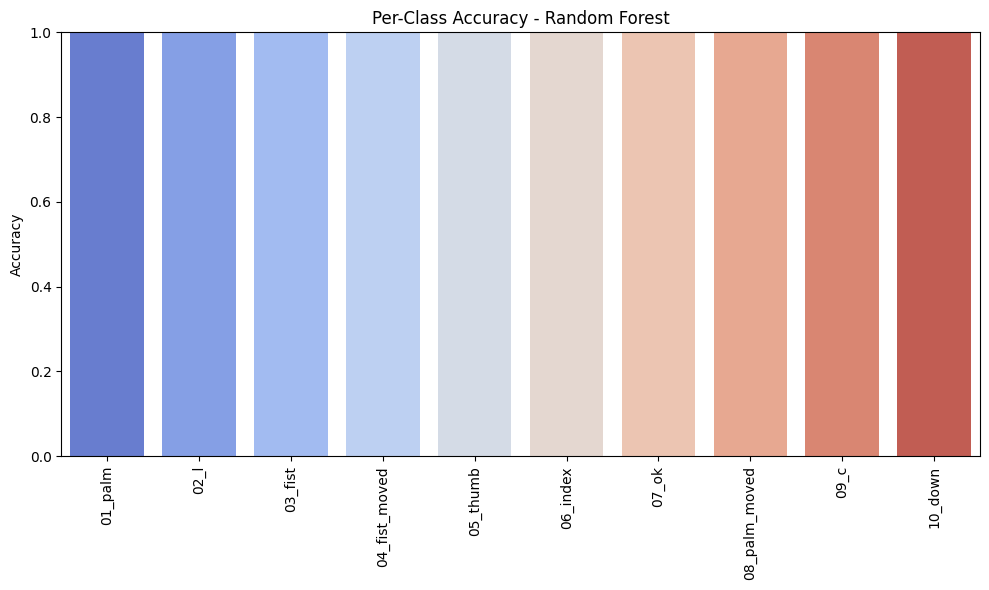

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, rf_pred)
class_wise_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(x=le.inverse_transform(np.arange(len(class_wise_acc))), y=class_wise_acc, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Per-Class Accuracy - Random Forest")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()

#### Plot accuracy comparison

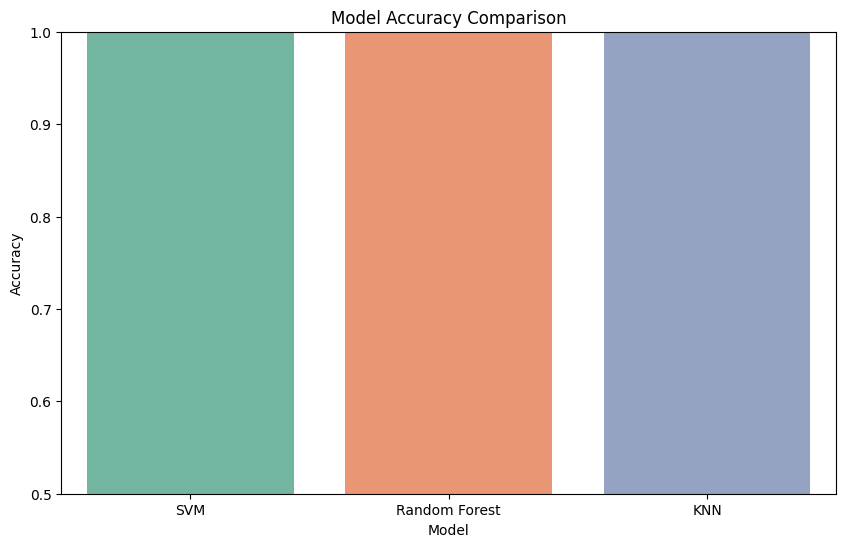

In [19]:
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", data=acc_df, palette="Set2")
plt.title("Model Accuracy Comparison")
plt.ylim(0.5, 1.0)
plt.show()

#### Validation Curve (Simulated Learning Curve)

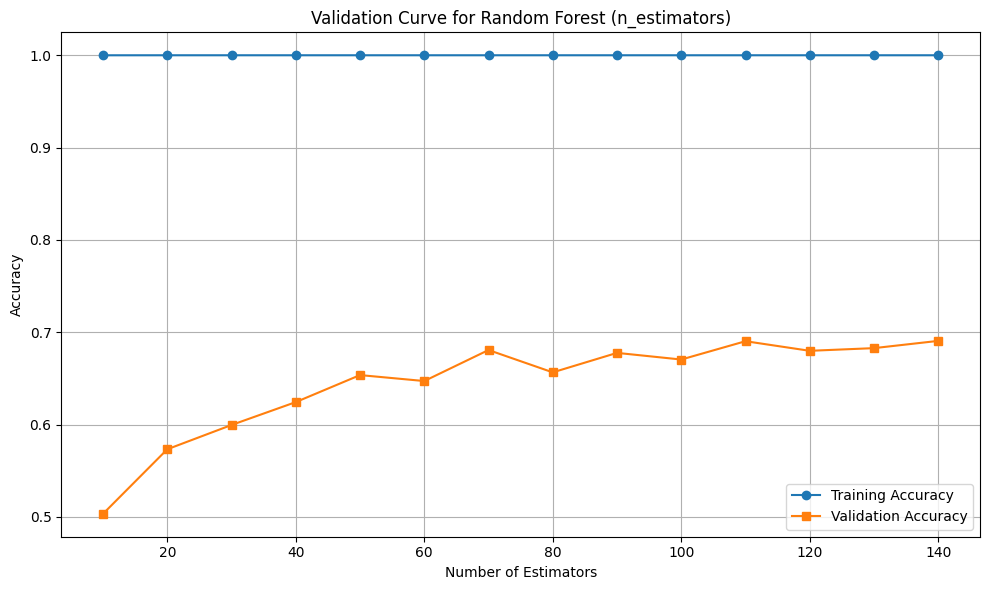

In [20]:
from sklearn.model_selection import validation_curve

param_range = np.arange(10, 150, 10)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(), X_pca, y_encoded,
    param_name="n_estimators",
    param_range=param_range,
    cv=3, scoring="accuracy"
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Accuracy", marker='o')
plt.plot(param_range, test_mean, label="Validation Accuracy", marker='s')
plt.title("Validation Curve for Random Forest (n_estimators)")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Confusion Matrix - SVM

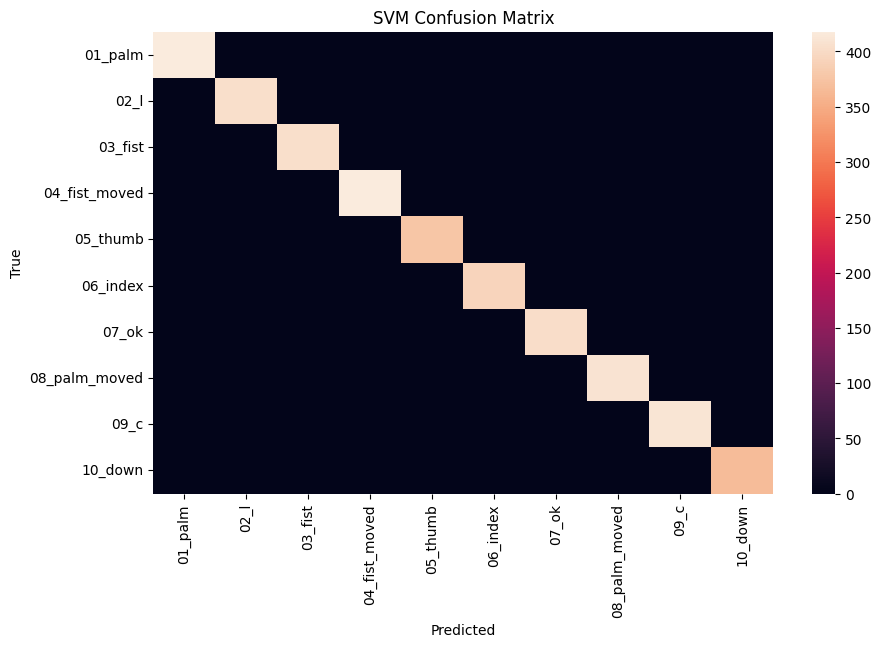

In [21]:
svm_cm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(10,6))
sns.heatmap(svm_cm, annot=False, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Classification Report - SVM

In [22]:
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred, target_names=le.classes_))

SVM Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       417
         02_l       1.00      1.00      1.00       404
      03_fist       1.00      1.00      1.00       404
04_fist_moved       1.00      1.00      1.00       418
     05_thumb       1.00      1.00      1.00       377
     06_index       1.00      1.00      1.00       392
        07_ok       1.00      1.00      1.00       403
08_palm_moved       1.00      1.00      1.00       409
         09_c       1.00      1.00      1.00       410
      10_down       1.00      1.00      1.00       366

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000



#### Multi-Class ROC AUC Curves

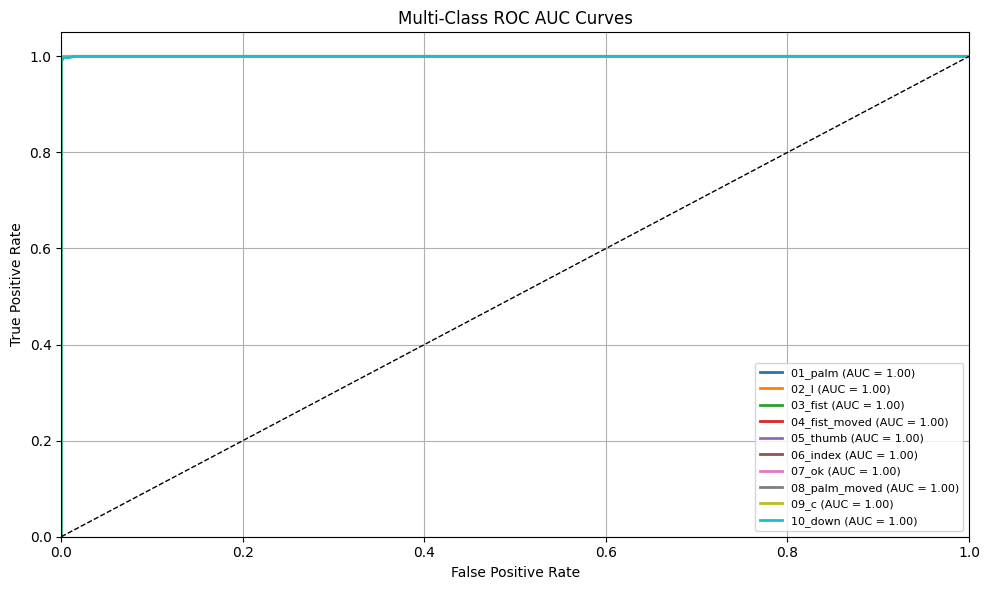

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

# Binarize labels for multi-class ROC
y_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_bin.shape[1]

# Wrap classifier for One-vs-Rest
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
classifier.fit(X_train, label_binarize(y_train, classes=np.arange(n_classes)))
y_score = classifier.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC AUC Curves')
plt.legend(loc='lower right', fontsize=8)
plt.grid()
plt.tight_layout()
plt.show()

#### Show Misclassified Images

In [24]:
mis_idx = np.where(rf_pred != y_test)[0]
plt.figure(figsize=(10, 6))
for i, idx in enumerate(mis_idx[:10]):
    img = X[idx]
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    true_label = le.inverse_transform([y_test[idx]])[0]
    pred_label = le.inverse_transform([rf_pred[idx]])[0]
    plt.title(f"T: {true_label}\nP: {pred_label}")
    plt.axis('off')
plt.suptitle("Sample Misclassifications - Random Forest")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

#### Save models and encoders

In [25]:
joblib.dump(svm_model, "Models/SVM_Model.pkl")
joblib.dump(rf_model, "Models/RF_Model.pkl")
joblib.dump(knn_model, "Models/KNN_Model.pkl")
joblib.dump(le, "Models/Label_Encoder.pkl")
joblib.dump(scaler, "Models/Scaler.pkl")
joblib.dump(pca, "Models/PCA.pkl")

['Models/PCA.pkl']

#### Choose best model

In [26]:
best_model_name = acc_df.loc[acc_df['Accuracy'].idxmax(), 'Model']
print("Best Model:", best_model_name)

Best Model: SVM


#### Load best model for use

In [27]:
model_paths = {"SVM": "Models/SVM_Model.pkl", "Random Forest": "Models/RF_Model.pkl", "KNN": "Models/KNN_Model.pkl"}
best_model = joblib.load(model_paths[best_model_name])

#### Gesture to Command Mapping

In [28]:
gesture_commands = {
    '01_palm': 'Stop', '02_l': 'Left', '03_fist': 'Start',
    '04_five': 'Open', '05_thumb': 'Thumbs Up', '06_c': 'Grab',
    '07_ok': 'Okay', '08_down': 'Down', '09_up': 'Up', '10_index': 'Point'
}

#### Prediction Function from Image

In [29]:
def predict_gesture_from_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (64, 64))
    features = hog(resized, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2))
    scaled = scaler.transform([features])
    reduced = pca.transform(scaled)
    probs = best_model.predict_proba(reduced)[0]
    pred_idx = np.argmax(probs)
    pred_label = le.inverse_transform([pred_idx])[0]
    command = gesture_commands.get(pred_label, "Unknown")
    confidence = probs[pred_idx]
    return pred_label, command, confidence

#### Real-Time Webcam Prediction (Standalone OpenCV)

In [30]:
def run_webcam_realtime():
    cap = cv2.VideoCapture(0)
    print("Press 's' to save snapshot, 'q' to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        pred_label, command, conf = predict_gesture_from_image(frame)
        cv2.putText(frame, f"Gesture: {pred_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
        cv2.putText(frame, f"Command: {command}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2)
        cv2.putText(frame, f"Conf: {conf*100:.2f}%", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,100,255), 2)
        cv2.imshow("Live Gesture Recognition", frame)
        key = cv2.waitKey(1)
        if key == ord('s'):
            fname = os.path.join(SNAPSHOT_DIR, f"snapshot_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
            cv2.imwrite(fname, frame)
            print(f"Snapshot saved to: {fname}")
        elif key == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

#### Run real-time prediction (only when you want standalone)

In [44]:
#run_webcam_realtime()

Press 's' to save snapshot, 'q' to quit.


#### Save predictions and snapshots from Gradio

In [32]:
def save_snapshot_and_predict(image_np):
    folder = os.path.join(SNAPSHOT_DIR, "gradio_snapshots")
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, f"gradio_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    cv2.imwrite(fname, cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))
    pred, command, conf = predict_gesture_from_image(cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))
    return fname, pred, command, f"{conf*100:.2f}%"

#### Draw prediction overlay (for webcam usage)

In [33]:
def draw_prediction_overlay(img, label, command, conf):
    overlay = img.copy()
    cv2.putText(overlay, f"Gesture: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(overlay, f"Command: {command}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(overlay, f"Confidence: {conf}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 100, 255), 2)
    return overlay

#### Safe Gradio prediction handler with fallback

In [34]:
def gradio_predict_safe(image_np, model_name):
    try:
        img_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
        label, command, conf = predict_gesture_from_image(img_bgr)
        overlay = draw_prediction_overlay(image_np, label, command, conf)
        return overlay, f"Gesture: {label}\nCommand: {command}\nConfidence: {conf*100:.2f}%"
    except Exception as e:
        return image_np, f"Error during prediction: {str(e)}"

#### Create snapshot directory with date

In [35]:
def make_snapshot_subfolder():
    today_folder = os.path.join(SNAPSHOT_DIR, datetime.now().strftime('%Y-%m-%d'))
    os.makedirs(today_folder, exist_ok=True)
    return today_folder

#### Save snapshot and log prediction

In [36]:
def save_snapshot(image_np, label, command, conf):
    folder = make_snapshot_subfolder()
    filename = os.path.join(folder, f"{label}_{datetime.now().strftime('%H%M%S')}.png")
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename, image_bgr)
    return filename

#### Extended predict + save function

In [37]:
def predict_and_save_snapshot(image_np, model_name):
    model = joblib.load(model_paths[model_name])
    gray = cv2.cvtColor(cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (64, 64))
    features = hog(resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    scaled = scaler.transform([features])
    reduced = pca.transform(scaled)
    probs = model.predict_proba(reduced)[0]
    idx = np.argmax(probs)
    label = le.inverse_transform([idx])[0]
    command = gesture_commands.get(label, "Unknown")
    conf = probs[idx]
    file_path = save_snapshot(image_np, label, command, f"{conf*100:.2f}")
    overlay = draw_prediction_overlay(image_np, label, command, f"{conf*100:.2f}")
    return overlay, f"Gesture: {label}\nCommand: {command}\nConfidence: {conf*100:.2f}%\nSaved to: {file_path}"

#### Import Gradio

In [38]:
import gradio as gr

#### Gradio prediction function

In [39]:
def gradio_predict(image_np, model_name):
    model_path = model_paths[model_name]
    model = joblib.load(model_path)
    img_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (64, 64))
    features = hog(resized, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2))
    scaled = scaler.transform([features])
    reduced = pca.transform(scaled)
    probs = model.predict_proba(reduced)[0]
    idx = np.argmax(probs)
    label = le.inverse_transform([idx])[0]
    command = gesture_commands.get(label, "Unknown")
    conf = probs[idx]
    
    log_prediction("Upload", model_name, label, command, f"{conf*100:.2f}%")
    return label, command, f"{conf*100:.2f}%"

#### Gradio snapshot + save + predict

In [40]:
def gradio_snap_and_predict(image_np, model_name):
    snapshot_file, label, command, conf = save_snapshot_and_predict(image_np)
    log_prediction("Webcam", model_name, label, command, conf)
    return image_np, f"Gesture: {label}\nCommand: {command}\nConfidence: {conf}"

#### Gradio Interface layout

In [41]:
def launch_gradio_interface():
    with gr.Blocks() as demo:
        gr.Markdown("##Hand Gesture Recognition - Real-Time + Upload\n---")

        model_dropdown = gr.Dropdown(["SVM", "Random Forest", "KNN"], value="SVM", label="Select Model")

        with gr.Tab("Upload Image"):
            img_input = gr.Image(type="numpy", label="Upload Gesture Image")
            label_out = gr.Textbox(label="Prediction")
            predict_btn = gr.Button("Predict")
            predict_btn.click(fn=gradio_predict, inputs=[img_input, model_dropdown], outputs=label_out)

        with gr.Tab("Webcam Snapshot"):
            cam_input = gr.Image(type="numpy", label="Take a Snap from Webcam")
            cam_output_img = gr.Image(label="Snapshot Preview")
            cam_output_info = gr.Textbox(label="Result")
            snap_btn = gr.Button("Snap & Predict")
            snap_btn.click(fn=gradio_snap_and_predict, inputs=[cam_input, model_dropdown],
                           outputs=[cam_output_img, cam_output_info])

        gr.Markdown("Snapshots will be saved in `SavedSnapshots/gradio_snapshots` folder.")

        demo.launch()

#### Run Gradio

In [42]:
launch_gradio_interface()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


#### View Latest Logs

In [43]:
def display_latest_logs(n=10):
    if os.path.exists(LOG_FILE):
        df = pd.read_csv(LOG_FILE)
        display(df.tail(n))
    else:
        print("No logs available.")

display_latest_logs()

No logs available.
